In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap


#import deepchem as dc
import sklearn as sk


from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import make_scorer 

#Normalizing
from sklearn import preprocessing

#For data split
from sklearn.model_selection import train_test_split 


#importing Random Forest packages
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import model_selection

# different model
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBRegressor
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
import lightgbm as lgb


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
## read data

## 1: sucks
## 2,3: useful

az = pd.read_csv('/Users/rz2333/Downloads/Study/BU/Novatis_hackason/Hack7/AZ_590Feature_Final.csv')
az_clu = pd.read_csv('/Users/rz2333/Downloads/Study/BU/Novatis_hackason/Hack7/annotation_col.csv')
az['IC50'] = az['SAU Gyr IC50 (礛)'].str.strip('>').str.strip('<').astype(float)
az['Censorship'] = 'normal'
az['Censorship'].loc[az['SAU Gyr IC50 (礛)'].str.contains('>')] = '>'
az['Censorship'].loc[az['SAU Gyr IC50 (礛)'].str.contains('<')] = '<'
az['logIC50'] = np.log(az['IC50'])

az['tree_clu'] = az_clu['tree']
#az.loc[az_clu['Unnamed: 0'],'tree_clu']
#az_clu['']

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
az_noR = az.loc[(az['Censorship'] != '>')]
y = az_noR['logIC50']
X = az_noR.drop(['logIC50', 'Censorship', 'IC50','Molecule SMILES', 'SAU Gyr IC50 (礛)', 'tree_clu'],axis=1)

#data split based on sythesis date into train test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.3, train_size=.6, random_state=0) #  ,return_train_score=True

X_train1, X_test1, y_train1, y_test1 = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

## Tune parameter

In [39]:
def custom_asymmetric_train(y, pred):
    a = 0.7
    
    y, pred = np.array(y), np.array(pred)
    #LS_idx = np.where(y<-4.6)
    #nor_idx = np.where(y>=-4.6)
    LS_idx = (y<-4.6) & (y>-4.63)
    nor_idx = (y>=-4.6) | (y<-4.63)
    
    y_LS = y[LS_idx]   ###-4.6 is the cutoff
    ypred_LS = pred[LS_idx]
    #LS_diff = (y_LS-ypred_LS).astype('float')
    LS_diff = (ypred_LS-y_LS).astype('float')
    grad_LS = np.where(LS_diff<0, 2*(-1+a)**2*LS_diff, 2*(1+a)**2*LS_diff)
    hess_LS = np.where(LS_diff<0, 2*(-1+a)**2, 2*(1+a)**2)
    
    # normal data
    y_nor = y[nor_idx] 
    ypred_nor = pred[nor_idx]
    nor_diff = (y_nor-ypred_nor).astype('float')
    grad_nor = -2*nor_diff
    hess_nor = np.array([2 for x in range(len(y_nor))])
    
    grad_total = np.zeros(len(y))
    grad_total[LS_idx] = grad_LS
    grad_total[nor_idx] = grad_nor
    
    hess_total = np.zeros(len(y))
    hess_total[LS_idx] = hess_LS
    hess_total[nor_idx] = hess_nor
    
    return grad_total, hess_total

In [40]:
XGB_NR = lgb.LGBMRegressor()
XGB_NR.set_params(**{'objective': custom_asymmetric_train}, metrics = ["mse", 'mae'])

kf = KFold(n_splits=5, shuffle=True)
cv_all = []
for train_index, test_index in kf.split(X_train1):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #print(len(test_index))
    #print(y_train.shape)
    #print(type(train_index))
    X_cvt, X_valid = X_train1.loc[train_index,:], X_train1.loc[test_index,:]
    y_cvt, y_valid = y_train1.loc[train_index], y_train1.loc[test_index]
    
    #print(X_cvt.shape)
    #print(y_cvt.shape)
    XGB_NR.fit(
    X_cvt,
    y_cvt,
    verbose=False)
    
    cv_pred = XGB_NR.predict(X_valid)
    r2 = r2_score(y_valid, cv_pred)
    print('r2 is {}'.format(r2))
    cv_all.append(r2)

print('average r2 is {}'.format(np.mean(cv_all)))



r2 is 0.6950440783185672
r2 is 0.6399893193560708
r2 is 0.6861907611394565
r2 is 0.6506202227229653
r2 is 0.45868156132808724
average r2 is 0.6261051885730294


In [119]:
path='/Users/rz2333/Downloads/Study/BU/Novatis_hackason/Hack7/result/'
"{}lgb_a{}.csv".format(path, 0.1)

'/Users/rz2333/Downloads/Study/BU/Novatis_hackason/Hack7/result/lgb_a0.1.csv'

## Leaderboard
### a=-0.9, mean r^2 = 0.5351819788178656
### a=-0.5, mean r^2 = 0.6058507467430668



### a=0.0, mean r^2 = 0.6400683894978534
### a=0.1, mean r^2 = 0.6140868407367919
### a=0.2, mean r^2 = 0.6150252407024285
### a=0.3, mean r^2 = 0.6150252407024285
### a=0.4, mean r^2 = 0.6374916317442667
### a=0.5, mean r^2 = 0.6394281504235058
### a=0.6, mean r^2 = 0.6261378230719419
### a=0.7, mean r^2 = 0.6395515177952324
### a=0.8, mean r^2 = 0.6367546541359685
### a=0.9, mean r^2 = 0.640622226989371
### a=1, mean r^2 = 0.6132576833088537


In [191]:
def custom_asymmetric_train(y, pred):
    a = 1
    
    y, pred = np.array(y), np.array(pred)
    #LS_idx = np.where(y<-4.6)
    #nor_idx = np.where(y>=-4.6)
    LS_idx = (y<-4.6) & (y>-4.63)
    nor_idx = (y>=-4.6) | (y<-4.63)
    
    y_LS = y[LS_idx]   ###-4.6 is the cutoff
    ypred_LS = pred[LS_idx]
    #LS_diff = (y_LS-ypred_LS).astype('float')
    LS_diff = (ypred_LS-y_LS).astype('float')
    grad_LS = np.where(LS_diff<0, 2*(-1+a)**2*LS_diff, 2*(1+a)**2*LS_diff)
    hess_LS = np.where(LS_diff<0, 2*(-1+a)**2, 2*(1+a)**2)
    
    # normal data
    y_nor = y[nor_idx] 
    ypred_nor = pred[nor_idx]
    nor_diff = (y_nor-ypred_nor).astype('float')
    grad_nor = -2*nor_diff
    hess_nor = np.array([2 for x in range(len(y_nor))])
    
    grad_total = np.zeros(len(y))
    grad_total[LS_idx] = grad_LS
    grad_total[nor_idx] = grad_nor
    
    hess_total = np.zeros(len(y))
    hess_total[LS_idx] = hess_LS
    hess_total[nor_idx] = hess_nor
    
    return grad_total, hess_total

XGB_NR = lgb.LGBMRegressor()
XGB_NR.set_params(**{'objective': custom_asymmetric_train}, metrics = ["mse", 'mae'])

XGB_NR.fit(
    X_train1,
    y_train1,
    verbose=False)

all_pred = XGB_NR.predict(az.loc[:,X_train1.columns])
path='/Users/rz2333/Downloads/Study/BU/Novatis_hackason/Hack7/result/'
np.savetxt("{}lgb_a{}.csv".format(path, 1), all_pred, delimiter=",")

## Test on testing dataset

In [166]:
import seaborn as sns
pred_NR = XGB_NR.predict(X_test)

plt.figure()
ax = sns.scatterplot(x=pred_NR, y=y_test)
ax.set(xlabel='prediction', ylabel='true value')
plt.show()

r2_score(y_test, pred_NR)

<IPython.core.display.Javascript object>

In [139]:
#%matplotlib notebook
FI_XGB = pd.DataFrame({"Feature Importance":XGB_NR.feature_importances_}, index=X_train.columns)
FI_XGB = FI_XGB.sort_values("Feature Importance",ascending=False)

FI_XGB[FI_XGB["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(7,10))
plt.xticks(rotation=90)
plt.show()

fea_sel = FI_XGB.loc[FI_XGB['Feature Importance']!= 0].index
FI_XGB.head(20)

<IPython.core.display.Javascript object>

,Feature Importance
MinAbsEStateIndex,107
SMR_VSA5,80
EState_VSA2,78
MaxEStateIndex,77
MinEStateIndex,76
BalabanJ,72
MolLogP,71
PEOE_VSA8,65
MinPartialCharge,61
MaxPartialCharge,60


In [35]:
### loading other validation dataset
path='/Users/rz2333/Downloads/Study/BU/Novatis_hackason/Hack7/'
test = pd.read_csv('{}/BindingDB_Gyrase_B_fea.tsv'.format(path))
#test['IC50'] = test['IC50']/1000
test['logIC50'] = np.log(test['IC50'])
test.head()


,Ligand SMILES,BalabanJ,BertzCT,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,...,fr_ether,fr_halogen,fr_methoxy,fr_piperdine,fr_pyridine,fr_thiazole,qed,Censorship,IC50,logIC50
0,CCNC(=O)Nc1nc2cc(-c3ccn(CCOC)c(=O)c3)c(OCC3CCO...,1.678579,1171.683200,0.000000,9.589074,11.590381,71.313612,13.027704,11.336786,23.940108,...,3.0,0.0,1.0,0.0,2.0,1.0,0.490757,<,0.0005,-7.600902
1,CCNC(=O)Nc1nc2cc(-c3ccn(C)c(=O)c3)c(OCC3CCOC3)...,1.706184,1120.072585,0.000000,9.589074,11.590381,58.161973,13.027704,15.903886,19.310883,...,2.0,0.0,0.0,0.0,2.0,1.0,0.623753,normal,0.0010,-6.907755
2,CO[C@H]1CN(CC[C@H]1NC(=O)c1[nH]c(C)c(Cl)c1Cl)c...,1.253287,1460.052735,5.969305,14.695602,39.340623,53.415001,44.060568,6.196844,20.230378,...,1.0,2.0,1.0,1.0,0.0,1.0,0.255990,normal,0.0012,-6.725434
3,CCNC(=O)c1cc2c(c(cnc2[nH]1)-c1cc(cnc1OC)-c1n[n...,1.787212,1681.173548,23.533469,22.760320,39.926107,17.494432,16.945014,31.636219,6.923737,...,1.0,3.0,1.0,0.0,2.0,0.0,0.312252,normal,0.0020,-6.214608
4,CCNC(=O)Nc1nc2cc(c(OCC3CCOC3)nc2s1)-c1ccn(CCN2...,1.402404,1282.303169,0.000000,9.589074,11.590381,64.706730,45.875737,11.336786,10.633467,...,3.0,0.0,0.0,0.0,2.0,1.0,0.434621,normal,0.0022,-6.119298


In [32]:
test_noR = test.loc[(test['Censorship'] != '>')]
y_test = test_noR['logIC50']
X_test = test_noR.drop(['logIC50', 'Censorship', 'IC50','Ligand SMILES'],axis=1)
X_test = X_test.loc[:,X.columns]

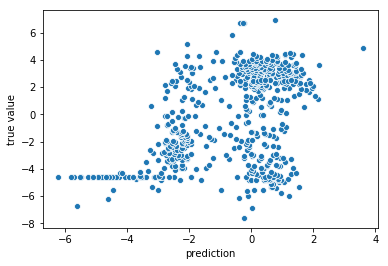

0.2501818054650461

In [36]:
test_pred = XGB_NR.predict(X_test)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
ax = sns.scatterplot(x=test_pred, y=y_test)
ax.set(xlabel='prediction', ylabel='true value')
plt.show()
r2_score(y_test, test_pred)

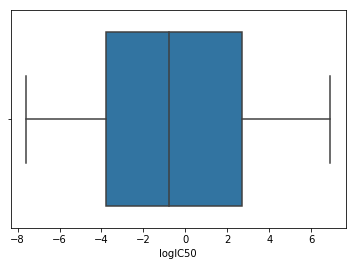

In [31]:
sns.boxplot(test['logIC50'])
plt.show()

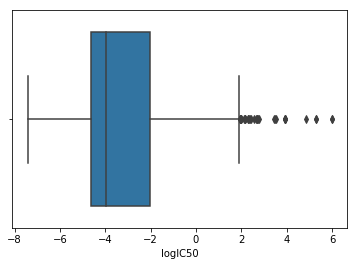

In [24]:
sns.boxplot(az['logIC50'])
plt.show()

In [19]:
sum(test['IC50']>400)

#test['IC50'].shape

(661,)